In [22]:
import numpy as np
import util
import matplotlib.pyplot as plt

In [23]:
n=25
d=25
M = np.random.rand(n,d)
l,v,r = np.linalg.svd(M)
v_full = np.append(np.diag(v), np.zeros((n-d,d)), axis=0)
RM = np.dot(np.dot(l,v_full), r)
print(np.linalg.norm(M - RM, ord='fro'))

5.46281270453e-14


In [24]:
# rank 3 approx
rank = 3
v3 = [v[i] if i < rank else 0 for i in range(len(v))]
v3_full = np.append(np.diag(v3), np.zeros((n-d,d)), axis=0)
RM3 = np.dot(np.dot(l,v3_full), r)
print(np.linalg.norm(M - RM3, ord='fro'))

6.02913148745


In [25]:
# set half of the values to 0
mask = np.random.randint(0,2,size=M.shape).astype(np.bool)
z = np.zeros((n,d))
RM3_zero = RM3.copy()
RM3_zero[mask] = z[mask]

In [26]:
def calc_error(R, P, Q, rank, beta):
    e = 0
    for i in range(len(R)):
        for j in range(len(R[i])):
            if R[i][j] > 0:
                e = e + pow(R[i][j] - np.dot(P[i,:],Q[:,j]), 2)
                for k in range(rank):
                    e = e + (beta/2) * ( pow(P[i][k],2) + pow(Q[k][j],2) )
    return e

In [27]:
def matrix_factorization_sgd(R, P, Q, K, steps=5000, alpha=0.0001, beta=0.02):
    Q = Q.T
    for step in range(steps):
        for i in range(len(R)):
            for j in range(len(R[i])):
                if R[i][j] > 0:
                    eij = R[i][j] - np.dot(P[i,:],Q[:,j])
                    for k in range(K):
                        P[i][k] = P[i][k] + alpha * (2 * eij * Q[k][j] - beta * P[i][k])
                        Q[k][j] = Q[k][j] + alpha * (2 * eij * P[i][k] - beta * Q[k][j])
        eR =  np.dot(P,Q)
    return P, Q.T

In [28]:
def matrix_factorization_SVRG(R, P, Q, rank, K, T, alpha, beta):
    Q = Q.T
    P_last = P
    Q_last = Q
    errors = [calc_error(R, P, Q, rank, beta)]
    #print(errors)
    e_old = 1000000
    for K_i in range(K):
        P_tilde = P_last
        Q_tilde = Q_last
        P_mu_tilde = np.zeros(P.shape)
        Q_mu_tilde = np.zeros(Q.shape)
        count = 0
        for i in range(len(R)):
            for j in range(len(R[i])):
                if R[i][j] > 0:
                    eij = R[i][j] - np.dot(P[i,:],Q[:,j])
                    count+=1
                    for k in range(rank):
                        P_mu_tilde[i][k] = P_mu_tilde[i][k]  + 2 * eij * Q_tilde[k][j] - beta * P_tilde[i][k]
                        Q_mu_tilde[k][j] = Q_mu_tilde[k][j] + 2 * eij * P_tilde[i][k] - beta * Q_tilde[k][j]
        P_mu_tilde = P_mu_tilde/(1.0*k)
        Q_mu_tilde = Q_mu_tilde/(1.0*k)
        for _ in range(T):
            for i in range(len(R)):
                for j in range(len(R[i])):
                    if R[i][j] > 0:
                        eij = R[i][j] - np.dot(P[i,:],Q[:,j])
                        for k in range(rank):
                            P[i][k] = P[i][k] + alpha * ((2 * eij * Q[k][j] - beta * P[i][k]) -(2 * eij * Q_tilde[k][j] - beta * P_tilde[i][k]) + P_mu_tilde[i][k])
                            Q[k][j] = Q[k][j] + alpha * ((2 * eij * P[i][k] - beta * Q[k][j]) -
                             (2* eij * P_tilde[i][k] - beta * Q_tilde[k][j]) + Q_mu_tilde[k][j])
        P_last = P
        Q_last = Q
        e = 0
        for i in range(len(R)):
            for j in range(len(R[i])):
                if R[i][j] > 0:
                    e = e + pow(R[i][j] - np.dot(P[i,:],Q[:,j]), 2)
                    for k in range(rank):
                        e = e + (beta/2) * ( pow(P[i][k],2) + pow(Q[k][j],2) )
        #print(errors)
        errors.append(e)
        #print(errors)
        #if e < 0.001 or e > e_old:
        #    break
        e_old = e
    return P, Q.T, errors

In [29]:
def quantize_num(n, s, qtype, vmin, vmax):
    n = n / s
    if n > vmax:
        return qtype(vmax)
    elif n < vmin:
        return qtype(vmin)
    else:
        n2 = qtype(n)
        if np.random.rand() > n%1 and n2 < vmax:
            return n2+1
        return n2

In [30]:
def matrix_factorization_SVRG_LP(R, P, Q, rank, K, T, alpha, beta, bits, data_type):
    Q = Q.T
    P_last = P
    Q_last = Q
    max_val = 1.0*((2**(bits-1))-1); min_val = -1.0*((2**(bits-1)))
    s = 1/(1.0*2**(bits-1))
    errors = [calc_error(R,P.astype(float)*s, Q.astype(float)*s, rank, beta)]
    e_old = 1000000
    for K_i in range(K):
        P_tilde = P_last
        Q_tilde = Q_last
        P_mu_tilde = np.zeros(P.shape)
        Q_mu_tilde = np.zeros(Q.shape)
        count = 0
        for i in range(len(R)):
            for j in range(len(R[i])):
                if R[i][j] > 0:
                    count+=1
                    eij = R[i][j] - np.dot(P[i,:].astype(float)*s,Q[:,j].astype(float)*s)
                    for k in range(rank):
                        P_mu_tilde[i][k] = P_mu_tilde[i][k]  + 2 * eij * Q_tilde[k][j].astype(float)*s - beta * P_tilde[i][k].astype(float)*s
                        Q_mu_tilde[k][j] = Q_mu_tilde[k][j] + 2 * eij * P_tilde[i][k].astype(float)*s - beta * Q_tilde[k][j].astype(float)*s
        P_mu_tilde = P_mu_tilde/(1.0*k)
        Q_mu_tilde = Q_mu_tilde/(1.0*k)
        for _ in range(T):
            for i in range(len(R)):
                for j in range(len(R[i])):
                    if R[i][j] > 0:
                        eij = R[i][j] - np.dot(P[i,:].astype(float)*s,Q[:,j].astype(float)*s)
                        for k in range(rank):
                            pik = float(P[i][k])*s; qkj = float(Q[k][j])*s;
                            qtkj = float(Q_tilde[k][j])*s; ptik = float(P_tilde[i][k])*s;
                            qkj = float(Q[k][j])*s; qtkj = float(Q_tilde[k][j])*s;
                            pik = pik + alpha * ((2 * eij * qkj - beta * pik) - (2 * eij * qtkj - beta * ptik) + P_mu_tilde[i][k])
                            qkj = qkj + alpha * ((2 * eij * pik - beta * qkj) - (2* eij * ptik - beta * qtkj) + Q_mu_tilde[k][j])
                            P[i][k] = quantize_num(pik, s, data_type, min_val, max_val)
                            Q[k][j] = quantize_num(qkj, s, data_type, min_val, max_val)
        P_last = P
        Q_last = Q
        e = 0
        for i in range(len(R)):
            for j in range(len(R[i])):
                if R[i][j] > 0:
                    e = e + pow(R[i][j] - np.dot(P[i,:].astype(float)*s,Q[:,j].astype(float)*s), 2)
                    for k in range(rank):
                        e = e + (beta/2) * ( pow(P[i][k].astype(float)*s,2) + pow(Q[k][j].astype(float)*s,2) )
        errors.append(e)
        #if e < 0.001 or e > e_old:
        #    break
        e_old = e
    return P.astype(float)*s, Q.T.astype(float)*s, errors

In [31]:
def matrix_factorization_HALP(R, P, Q, rank, K, T, alpha, beta, bits, data_type):
    Q = Q.T
    max_val = 1.0*((2**(bits-1))-1); min_val = -1.0*((2**(bits-1)))
    s = 0
    errors = [calc_error(R,P, Q, rank, beta)]
    e_old = 1000000
    ZP = np.zeros(P.shape,dtype=data_type)
    ZQ = np.zeros(Q.shape,dtype=data_type)
    s = 0.0
    for K_i in range(K):
        P = P + ZP.astype(float)*s
        Q = Q + ZQ.astype(float)*s
        P_mu_tilde = np.zeros(P.shape)
        Q_mu_tilde = np.zeros(Q.shape)
        count = 0
        for i in range(len(R)):
            for j in range(len(R[i])):
                if R[i][j] > 0:
                    count+=1
                    eij = R[i][j] - np.dot(P[i,:].astype(float)*s,Q[:,j].astype(float)*s)
                    for k in range(rank):
                        P_mu_tilde[i][k] = P_mu_tilde[i][k]  + 2 * eij * Q[k][j] - beta * P[i][k]
                        Q_mu_tilde[k][j] = Q_mu_tilde[k][j] + 2 * eij * P[i][k] - beta * Q[k][j]
        P_mu_tilde = P_mu_tilde/(1.0*k)
        Q_mu_tilde = Q_mu_tilde/(1.0*k)
        p_sq = np.squeeze(np.asarray(P_mu_tilde))
        q_sq = np.squeeze(np.asarray(Q_mu_tilde))
        mag = ((np.linalg.norm(p_sq)**2) + (np.linalg.norm(q_sq)**2))**(0.5)
        mu = 3000
        s = mag/(mu*((2**(bits-1))-1))
        ZP = np.zeros(P.shape,dtype=data_type)
        ZQ = np.zeros(Q.shape,dtype=data_type)
        for _ in range(T):
            for i in range(len(R)):
                for j in range(len(R[i])):
                    if R[i][j] > 0:
                        eij = R[i][j] - np.dot(P[i,:]+ZP[i,:].astype(float)*s,Q[:,j]+ZQ[:,j].astype(float)*s)
                        for k in range(rank):
                            zpik = float(ZP[i][k])*s; zqkj = float(ZQ[k][j])*s
                            zpik = zpik - alpha * ((2 * eij * (Q[k][j]+zqkj) - beta * (P[i][k])+zpik) -(2 * eij * Q[k][j] - beta * P[i][k]) + P_mu_tilde[i][k])
                            zqkj = zqkj - alpha * ((2 * eij * (P[i][k]+zpik) - beta * (Q[k][j]+zqkj)) - (2* eij * P[i][k] - beta * Q[k][j]) + Q_mu_tilde[k][j])
                            ZP[i][k] = quantize_num(zpik, s, data_type, min_val, max_val)
                            ZQ[k][j] = quantize_num(zqkj, s, data_type, min_val, max_val)
        e = 0
        for i in range(len(R)):
            for j in range(len(R[i])):
                if R[i][j] > 0:
                    e = e + pow(R[i][j] - np.dot(P[i,:]+ZP[i,:].astype(float)*s,Q[:,j]+ZQ[:,j].astype(float)*s), 2)
                    for k in range(rank):
                        e = e + (beta/2) * ( pow(P[i][k]+float(ZP[i][k])*s,2) + pow(Q[k][j]+float(ZQ[k][j])*s,2) )
        errors.append(e)
        #if e < 0.001 or e > e_old:
         #   break
        e_old = e
    return P + ZP.astype(float)*s, Q.T + ZQ.T.astype(float)*s, errors

In [32]:
def matrix_factorization_HALP2(R, P, Q, rank, K, T, alpha, beta, bits, data_type):
    Q = Q.T
    max_val = 1.0*((2**(bits-1))-1); min_val = -1.0*((2**(bits-1)))
    s = 0
    errors = [calc_error(R,P, Q, rank, beta)]
    e_old = 1000000
    ZP = np.zeros(P.shape,dtype=data_type)
    ZQ = np.zeros(Q.shape,dtype=data_type)
    sP = 0.0; sQ = 0.0
    for K_i in range(K):
        P = P + ZP.astype(float)*sP
        Q = Q + ZQ.astype(float)*sQ
        P_mu_tilde = np.zeros(P.shape)
        Q_mu_tilde = np.zeros(Q.shape)
        count = 0
        for i in range(len(R)):
            for j in range(len(R[i])):
                if R[i][j] > 0:
                    count+=1
                    eij = R[i][j] - np.dot(P[i,:].astype(float)*sP,Q[:,j].astype(float)*sQ)
                    for k in range(rank):
                        P_mu_tilde[i][k] = P_mu_tilde[i][k]  + 2 * eij * Q[k][j] - beta * P[i][k]
                        Q_mu_tilde[k][j] = Q_mu_tilde[k][j] + 2 * eij * P[i][k] - beta * Q[k][j]
        P_mu_tilde = P_mu_tilde/(1.0*k)
        Q_mu_tilde = Q_mu_tilde/(1.0*k)
        p_sq = np.squeeze(np.asarray(P_mu_tilde))
        q_sq = np.squeeze(np.asarray(Q_mu_tilde))
        mu = 30000
        sP = (np.linalg.norm(p_sq)**2)/(mu*((2**(bits-1))-1))
        sQ = (np.linalg.norm(q_sq)**2)/(mu*((2**(bits-1))-1))
        ZP = np.zeros(P.shape,dtype=data_type)
        ZQ = np.zeros(Q.shape,dtype=data_type)
        for _ in range(T):
            for i in range(len(R)):
                for j in range(len(R[i])):
                    if R[i][j] > 0:
                        eij = R[i][j] - np.dot(P[i,:]+ZP[i,:].astype(float)*sP,Q[:,j]+ZQ[:,j].astype(float)*sQ)
                        for k in range(rank):
                            zpik = float(ZP[i][k])*sP; zqkj = float(ZQ[k][j])*sQ
                            zpik = zpik - alpha * ((2 * eij * (Q[k][j]+zqkj) - beta * (P[i][k])+zpik) -(2 * eij * Q[k][j] - beta * P[i][k]) + P_mu_tilde[i][k])
                            zqkj = zqkj - alpha * ((2 * eij * (P[i][k]+zpik) - beta * (Q[k][j]+zqkj)) - (2* eij * P[i][k] - beta * Q[k][j]) + Q_mu_tilde[k][j])
                            ZP[i][k] = quantize_num(zpik, sP, data_type, min_val, max_val)
                            ZQ[k][j] = quantize_num(zqkj, sQ, data_type, min_val, max_val)
        e = 0
        for i in range(len(R)):
            for j in range(len(R[i])):
                if R[i][j] > 0:
                    e = e + pow(R[i][j] - np.dot(P[i,:]+ZP[i,:].astype(float)*sP,Q[:,j]+ZQ[:,j].astype(float)*sQ), 2)
                    for k in range(rank):
                        e = e + (beta/2) * ( pow(P[i][k]+float(ZP[i][k])*sP,2) + pow(Q[k][j]+float(ZQ[k][j])*sQ,2) )
        errors.append(e)
        #if e < 0.001 or e > e_old:
         #   break
        e_old = e
    return P + ZP.astype(float)*sP, Q.T + ZQ.T.astype(float)*sQ, errors

In [33]:
def handle_SVRG(epochs, sgd_updates, P_init, Q_init, alpha, beta):
    rank = 3
    nP, nQ, errors = matrix_factorization_SVRG(RM3_zero, P_init, Q_init, rank, epochs, sgd_updates, alpha, beta)
    RM3_est = np.dot(nP,nQ.T)
    RM3_est_z = RM3_est.copy()
    RM3_est_z[mask] = z[mask]
    print(np.linalg.norm(RM3_est_z - RM3_zero, ord='fro'))
    print(np.linalg.norm(RM3_est - RM3, ord='fro'))
    return errors

In [34]:
def handle_SVRG_LP(epochs, sgd_updates, P_init, Q_init, bits, data_type, alpha, beta):
    rank = 3
    nP, nQ, errors = matrix_factorization_SVRG_LP(RM3_zero, P_init, Q_init, rank, epochs, sgd_updates, alpha, beta, bits, data_type)
    RM3_est = np.dot(nP,nQ.T)
    RM3_est_z = RM3_est.copy()
    RM3_est_z[mask] = z[mask]
    print(np.linalg.norm(RM3_est_z - RM3_zero, ord='fro'))
    print(np.linalg.norm(RM3_est - RM3, ord='fro'))
    return errors

In [35]:
def handle_HALP(epochs, sgd_updates, P_init, Q_init, bits, data_type, alpha, beta):
    rank = 3
    nP, nQ, errors = matrix_factorization_HALP(RM3_zero, P_init, Q_init, rank, epochs, sgd_updates, alpha, beta, bits, data_type)
    RM3_est = np.dot(nP,nQ.T)
    RM3_est_z = RM3_est.copy()
    RM3_est_z[mask] = z[mask]
    print(np.linalg.norm(RM3_est_z - RM3_zero, ord='fro'))
    print(np.linalg.norm(RM3_est - RM3, ord='fro'))
    return errors

In [36]:
def handle_HALP2(epochs, sgd_updates, P_init, Q_init, bits, data_type, alpha, beta):
    rank = 3
    nP, nQ, errors = matrix_factorization_HALP2(RM3_zero, P_init, Q_init, rank, epochs, sgd_updates, alpha, beta, bits, data_type)
    RM3_est = np.dot(nP,nQ.T)
    RM3_est_z = RM3_est.copy()
    RM3_est_z[mask] = z[mask]
    print(np.linalg.norm(RM3_est_z - RM3_zero, ord='fro'))
    print(np.linalg.norm(RM3_est - RM3, ord='fro'))
    return errors

In [53]:
P_gen = np.random.randint(2**15, size=(n, rank),dtype=np.int16)
Q_gen = np.random.randint(2**15, size=(d, rank),dtype=np.int16)
s = 1/(1.0*2**15)
P_full_gen = P_gen.astype(float)*s
Q_full_gen = Q_gen.astype(float)*s
alpha = 0.0001
beta = 0.02

In [58]:
errors_SVRG = handle_SVRG(20,50,P_full_gen.copy(), Q_full_gen.copy(),alpha, beta)

2.09591365883
3.86845605495


In [59]:
errors_LP_SVRG = handle_SVRG_LP(20,50, P_gen.copy(), Q_gen.copy(), 8, np.int8, alpha, beta)

40.7327732271
59.3949141052


In [60]:
errors_HALP = handle_HALP(20,50, P_full_gen.copy(), Q_full_gen.copy(), 8, np.int8, alpha, beta)

6.54725841798
9.74356719758


In [61]:
errors_HALP2 = handle_HALP2(20,50, P_full_gen.copy(), Q_full_gen.copy(), 8, np.int8, alpha, beta)

7.15727689069
10.5701538823


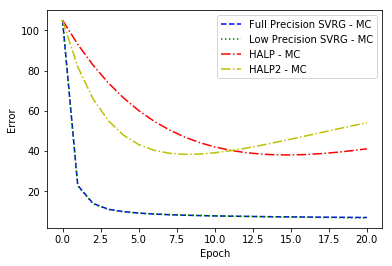

In [42]:
#util.draw_line_graph3(errors_SVRG, errors_LP_SVRG, errors_HALP, "error", "epochs")
fig, ax = plt.subplots()
ax.plot(errors_SVRG, 'k--', color='b', label='Full Precision SVRG - MC')
ax.plot(errors_LP_SVRG, 'k:',color='g', label='Low Precision SVRG - MC')
ax.plot(errors_HALP, 'k-.',color='r', label='HALP - MC')
ax.plot(errors_HALP2, 'k-.',color='y', label='HALP2 - MC')

plt.xlabel('Epoch')
plt.ylabel('Error')

legend = ax.legend(loc='upper right')
legend.get_frame()

plt.show()

In [53]:
## Dealing with bit shifts ##

In [54]:
c=3
s_blue = c/((1.0)*2**7)
s_green = c/((1.0)*2**15)
blue = np.random.randint(2**7, size=(1, 3),dtype=np.int8)
blue_full = blue.astype(float)*s_blue
green = np.random.randint(2**15, size=(1, 3),dtype=np.int16)
green_full = green.astype(float)*s_green

In [117]:
print("full addition:")
green_full + blue_full

full addition:


array([[ 0.69598389,  4.89633179,  3.00357056]])

In [118]:
c2 = np.array([np.left_shift(x,8) for x in blue.astype(np.int16)]).astype(np.int32) + green

In [119]:
c2*s_green

array([[ 0.69598389,  4.89633179,  3.00357056]])